In [1]:
from copy import deepcopy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 7)
plt.style.use('ggplot')
from sklearn.datasets import make_blobs
import random
from datetime import date, timedelta, datetime
from dateutil import parser
from csv import DictWriter
import csv
import time

In [2]:
start_time = time.time()

In [3]:
# Importing the dataset and optimizing it in order to form clusters based on every month
def input_file_optimize(date):
    usecols = list(range(1,2)) + list(range(7,671))
    data = pd.read_csv('Query_3_result.csv', nrows=50, usecols=usecols, header=None).T.to_csv('output.csv', header=False, index=False)
    t=pd.read_csv('output.csv', parse_dates=['States_New'])
    t['States_New'] = pd.to_datetime(t['States_New'], errors='coerce')
    mask = (t['States_New'].dt.to_period('M') == pd.to_datetime(date).to_period('M')) 
    month=t.loc[mask]
    col=month.head()
    column=list(col)
    l=[]    
    for i in column:
        if i=='States_New':
            continue
        else:
            l.extend(month[i].values)
    X = np.array(list(zip(l)))
    return X

In [4]:
def get_initial_centroids(X, k):
    """
    Function picks k random data points from dataset X, recurring points are removed and replaced but new points
    so a result we have array of k unique points. Founded points can be used as intial centroids for k means algorithm
    Args:
        X (numpy.ndarray) : dataset points array, size N:D
        k (int): number of centroids

    Returns:
        (numpy.ndarray): array of k unique initial centroids, size K:D

    """
    numsam = X.shape[0]
    points_for_centroids = random.sample(range(0, numsam), k)

    centroids = [tuple(X[id]) for id in points_for_centroids]
    unique_centroids = list(set(centroids))

    number_of_unique_centroids = len(unique_centroids)

    while number_of_unique_centroids < k:
        new_sample_points_ids = random.sample(range(0, numsam), k - number_of_unique_centroids)
        new_centroids = [tuple(X[id]) for id in new_sample_points_ids]
        unique_centroids = list(set(unique_centroids + new_centroids))
        number_of_unique_centroids = len(unique_centroids)

    return np.array(unique_centroids)

In [5]:
def get_euclidean_distance(A_matrix, B_matrix):
    """
    Function computes euclidean distance between matrix A and B.
    E. g. C[2,15] is distance between point 2 from A (A[2]) matrix and point 15 from matrix B (B[15])
    Args:
        A_matrix (numpy.ndarray): Matrix size N1:D
        B_matrix (numpy.ndarray): Matrix size N2:D

    Returns:
        numpy.ndarray: Matrix size N1:N2
    """

    A_square = np.reshape(np.sum(A_matrix * A_matrix, axis=1), (A_matrix.shape[0], 1))
    B_square = np.reshape(np.sum(B_matrix * B_matrix, axis=1), (1, B_matrix.shape[0]))
    AB = A_matrix @ B_matrix.T

    C = -2 * AB + B_square + A_square

    return np.sqrt(C)

In [6]:
def get_clusters(X, centroids, distancemeasuring_method):
    """
    Function finds k centroids and assigns each of the N points of array X to one centroid
    Args:
        X (numpy.ndarray): array of sample points, size N:D
        centroids (numpy.ndarray): array of centroids, size K:D
        distance_mesuring_method (function): function taking 2 Matrices A (N1:D) and B (N2:D) and returning distance
        between all points from matrix A and all points from matrix B, size N1:N2

    Returns:
        dict {cluster_number: list_of_points_in_cluster}
    """

    k = centroids.shape[0]

    clusters = {}

    distance_matrix = distancemeasuring_method(X, centroids)

    closest_cluster_ids = np.argmin(distance_matrix, axis=1)

    for i in range(k):
        clusters[i] = []

    for i, cluster_id in enumerate(closest_cluster_ids):
        clusters[cluster_id].append(X[i])
    
    with open(r'clusters.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow(clusters)
    return clusters

In [7]:
def has_centroids_covered(old_centroids, new_centroids, distancemeasuring_method, movement_threshold_delta):
    """
    Function checks if any of centroids moved more then MOVEMENT_THRESHOLD_DELTA if not we assume the centroids were founded
    Args:
        previous_centroids (numpy.ndarray): array of k old centroids, size K:D
        new_centroids (numpy.ndarray): array of k new centroids, size K:D
        distance_mesuring_method (function): function taking 2 Matrices A (N1:D) and B (N2:D) and returning distance
        movement_threshold_delta (float): threshold value, if centroids move less we assume that algorithm covered


    Returns: boolean True if centroids coverd False if not

    """
    distances_between_old_and_new_centroids = distancemeasuring_method(old_centroids, new_centroids)
    centroids_covered = np.max(distances_between_old_and_new_centroids.diagonal()) <= movement_threshold_delta

    return centroids_covered



In [8]:
def perform_k_means_algorithm(X, k, distancemeasuring_method, movement_threshold_delta=0):
    """
    Function performs k-means algorithm on a given dataset, finds and returns k centroids
    Args:
        X (numpy.ndarray) : dataset points array, size N:D
        distance_mesuring_method (function): function taking 2 Matrices A (N1:D) and B (N2:D) and returning distance
        between all points from matrix A and all points from matrix B, size N1:N2.
        k (int): number of centroids
        movement_threshold_delta (float): threshold value, if centroids move less we assume that algorithm covered

    Returns:
        (numpy.ndarray): array of k centroids, size K:D
    """

    new_centroids = get_initial_centroids(X=X, k=k)

    centroids_covered = False

    while not centroids_covered:
        old_centroids = new_centroids
        clusters = get_clusters(X, old_centroids, distancemeasuring_method)

        new_centroids = np.array([np.mean(clusters[key], axis=0, dtype=X.dtype) for key in sorted(clusters.keys())])

        centroids_covered = has_centroids_covered(old_centroids, new_centroids, distancemeasuring_method, movement_threshold_delta)

    return new_centroids

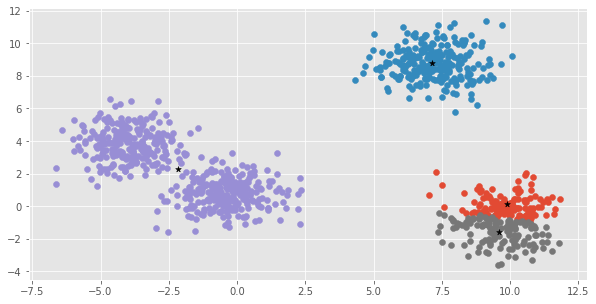

--- 0.40407443046569824 seconds ---


In [9]:
k = 4

X, _ = make_blobs(n_samples=1000, n_features=2, centers=k)

centroids = perform_k_means_algorithm(X, k, movement_threshold_delta=1/10, distancemeasuring_method=get_euclidean_distance)

clusters = get_clusters(X, centroids, get_euclidean_distance)

plt.rcParams['figure.figsize'] = [10, 5]
for centroid, points in clusters.items():
    points = np.array(points)
    centroid = np.mean(points, axis=0)


    plt.scatter(points[:, 0], points[:, 1], marker='o')
    plt.grid()
    plt.scatter(centroid[0], centroid[1], marker='*', color="black")

plt.show()
print("--- %s seconds ---" % (time.time() - start_time))